In [179]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix

In [46]:
df = pd.read_csv('../Data/subredditdatacleaned.csv')

In [47]:
df.head(2)

,Unnamed: 0,title,selftext,subreddit,created_utc
0,0,Do the crazy customers realize that they becom...,removed_asdf_fix,0,1636729943
1,1,Store music volume controls,"My most recent job, and hopefully last, in ret...",0,1636729678


In [48]:
df = df.drop(columns=['Unnamed: 0'])

# TalesFromRetail: 0, TalesFromTechSupport: 1

In [49]:
df.head()

,title,selftext,subreddit,created_utc
0,Do the crazy customers realize that they becom...,removed_asdf_fix,0,1636729943
1,Store music volume controls,"My most recent job, and hopefully last, in ret...",0,1636729678
2,Ways of Rejection,I'll just hop right into it as there's no poin...,0,1636725427
3,JUST TELL US WHAT IT'S USED FOR!,removed_asdf_fix,0,1636694714
4,You've got to go collect stray shopping carts ...,removed_asdf_fix,0,1636679308


In [50]:
df['subreddit'].value_counts(normalize=True)

1    0.501878
0    0.498122
Name: subreddit, dtype: float64

### Our baseline accuracy rate will be 50.18%, based of distribution above

# Setting our X,y and creating our Train/Test split

In [77]:
df['subreddit'] = df['subreddit'].map({0: 'TalesFromRetail', 1: 'TalesFromTechSupport'})

In [116]:
df['all_words'] = df['title'] + df['selftext']

In [117]:
features = ['title', 'selftext'] 
X = df['all_words']
y = df['subreddit']

In [105]:
y.value_counts()

TalesFromTechSupport    1470
TalesFromRetail         1459
Name: subreddit, dtype: int64

In [106]:
X.shape

(2929,)

In [107]:
y.shape

(2929,)

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [109]:
X_train.shape

(2196,)

In [110]:
y_train.shape

(2196,)

In [111]:
X_test.shape

(733,)

In [112]:
y_test.shape

(733,)

In [113]:
y_train.value_counts()

TalesFromTechSupport    1105
TalesFromRetail         1091
Name: subreddit, dtype: int64

# Creating our Pipe

In [143]:
import nltk
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append('removed_asdf_fix') # adding stop word
# Inspiration https://stackoverflow.com/questions/5511708/adding-words-to-nltk-stoplist

In [160]:
word_tokenize(df['title'][0])

['Do',
 'the',
 'crazy',
 'customers',
 'realize',
 'that',
 'they',
 'become',
 'a',
 'joke',
 'after',
 'they',
 'leave',
 '?']

In [141]:
tokenizer = CountVectorizer().build_tokenizer()

In [121]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('model', LogisticRegression(max_iter=1_000))
])

In [163]:
params = {
    'cvec__stop_words': [None, 'english'],
    'cvec__min_df': [3, 4, 5],
    'cvec__max_df':[.25, .3, .35],
    'cvec__binary': [True, False],
    'cvec__ngram_range': [(1,2)]
}
gs = GridSearchCV(pipe, param_grid=params)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.8601905156347069


{'cvec__binary': True,
 'cvec__max_df': 0.3,
 'cvec__min_df': 4,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english'}

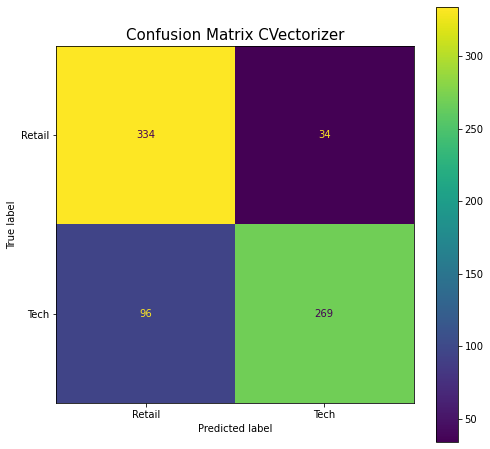

In [192]:
# inspiration https://stackoverflow.com/questions/61325314/how-to-change-plot-confusion-matrix-default-figure-size-in-sklearn-metrics-packa
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(gs, X_test, y_test, display_labels=['Retail', 'Tech'], ax=ax)
plt.title('Confusion Matrix CVectorizer', size=15);

In [166]:
pipe2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', LogisticRegression(max_iter=1_000))
])

In [177]:
params2 = {
    'tfidf__stop_words': [None, 'english'],
    'tfidf__min_df': [2, 3, 4],
    'tfidf__max_df':[.25, .3, .35],
    'tfidf__binary': [True, False],
    'tfidf__ngram_range': [(1,1),(1,2)]
}
gs1 = GridSearchCV(pipe2, param_grid=params2)
gs1.fit(X_train, y_train)
print(gs1.best_score_)
gs1.best_params_

0.8820501138952164


{'tfidf__binary': True,
 'tfidf__max_df': 0.3,
 'tfidf__min_df': 3,
 'tfidf__ngram_range': (1, 1),
 'tfidf__stop_words': 'english'}

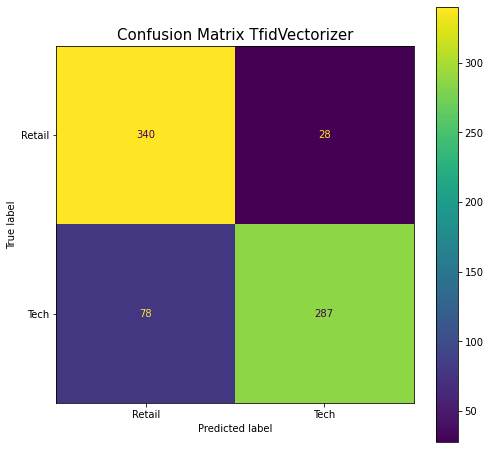

In [191]:
# inspiration https://stackoverflow.com/questions/61325314/how-to-change-plot-confusion-matrix-default-figure-size-in-sklearn-metrics-packa
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(gs1, X_test, y_test, display_labels=['Retail', 'Tech'], ax=ax)
plt.title('Confusion Matrix TfidVectorizer', size=15);